__Zarr Development Notebooks__</br>
<img src="http://static1.squarespace.com/static/530979d9e4b04bff4a3aadf5/t/5446c34ce4b0e5a2c7ff2614/1413923661373/DewberryLogo_RGB.png?format=1500w" width="40%" align='right'/>
__Probability Risk: Post Processor Group__</br>
PYTHON 3.6</br>
Overview: This notebook is to analyze how to store WSE tifs from multiple models into one cube of data.</br>
Updated 2018-10-15</br>
by Stephen Duncan: sduncan@dewberry.com <br/>

*Use Environment with boto3, zarr, & s3fs*

# Math With Zarr Arrays

We can read in and create a heat map of water surface elevations based on data saved in the Zarr Arrays

# Python Librarys Needed

In [1]:
import os, sys, time, glob, s3fs, zarr, json, boto3
import pathlib as pl
import numpy as np
import pandas as pd
from io import BytesIO
from osgeo import gdal, osr
from matplotlib import pyplot as plt
from IPython.display import display, Markdown, Latex
%matplotlib inline

import zarr_aws #Script with functions

# Define and read in zarr group

In [2]:
bucket2 = 'probmodelingrepository'
prefix2 = 'zarr'
zarr_file_name = 'demo.zarr'
zarr_file = f's3://{bucket2}/{prefix2}/{zarr_file_name}'
zarr_path = 'Bool'

In [3]:
zarr_store = s3fs.S3Map(root=zarr_file, s3=s3fs.S3FileSystem(), check=False)
z = zarr.open_group(store=zarr_store, path=zarr_path, mode='r')

# Read in the bool arrays

In [4]:
zarrays = []
zarr_path = 'Bool'
for key in z.attrs.keys():
    zg = zarr.open_group(store=zarr_store, path=f'{zarr_path}/{key}', mode='r')
    for ckey in zg.attrs.keys():
        print(f'path:{zarr_path}/{key} | key: {key}, ckey: {ckey}')
        zrry = zg[ckey]
        zarrays.append(zrry)

path:Bool/WSE_Pluvial_E001 | key: WSE_Pluvial_E001, ckey: r0_c0
path:Bool/WSE_Pluvial_E002 | key: WSE_Pluvial_E002, ckey: r0_c0
path:Bool/WSE_Pluvial_E003 | key: WSE_Pluvial_E003, ckey: r0_c0
path:Bool/WSE_Pluvial_E008 | key: WSE_Pluvial_E008, ckey: r0_c0
path:Bool/WSE_Pluvial_E050 | key: WSE_Pluvial_E050, ckey: r0_c0
path:Bool/WSE_Pluvial_E094 | key: WSE_Pluvial_E094, ckey: r0_c0
path:Bool/WSE_Pluvial_E1139 | key: WSE_Pluvial_E1139, ckey: r0_c0
path:Bool/WSE_Pluvial_E1181 | key: WSE_Pluvial_E1181, ckey: r0_c0
path:Bool/WSE_Pluvial_E1182 | key: WSE_Pluvial_E1182, ckey: r0_c0


In [5]:
zrry.shape

(13252, 13549)

# Create a local zarr array to store results to

this particular array can start from zero. We can make a zero array to start with!

In [6]:
root = pl.PurePath(os.getcwd())
data_dir = root / 'data'
heat_zarr = data_dir / 'heatmap.zarr'

# Start adding arrays to the hard disk zarr

This example here can create a sort of heat map for where pluvial flooding has occured

In [7]:
start_time = time.time()
z_hm = zarr.zeros(store=str(heat_zarr), shape=zrry.shape, chunks=(1000, 1000), dtype='i4', overwrite=True)
z_hm = zarr.open(str(heat_zarr), mode='a', shape=zrry.shape)
z_hmnp = np.array(z_hm)
for i, zrry in enumerate(zarrays):
    zrry_np = np.array(zrry)
    z_hmnp = np.add(z_hmnp, zrry_np)
    print(f'Progress at {i}: {(time.time()-start_time)/60:0.2f} Minutes')
z_hm = zarr.array(z_hmnp,store=str(heat_zarr),shape=z_hmnp.shape, overwrite=True)
print(f'Total Time: {(time.time()-start_time)/60:0.2f} Minutes')

Progress at 0: 0.54 Minutes
Progress at 1: 1.04 Minutes
Progress at 2: 1.55 Minutes
Progress at 3: 2.03 Minutes
Progress at 4: 2.50 Minutes
Progress at 5: 3.00 Minutes
Progress at 6: 3.45 Minutes
Progress at 7: 3.92 Minutes
Progress at 8: 4.39 Minutes
Total Time: 4.46 Minutes


## Id that math worked with arrays

In [8]:
np.unique(z_hmnp)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

# Quick Plot the results Below

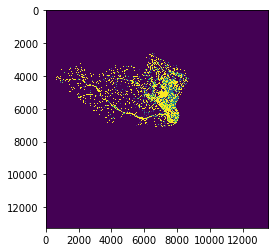

In [9]:
plt.imshow(z_hmnp)